In [1]:
#This code uses 3D Unet to train a network on 3D subvolumes (64x64x64).
#It also segments a large volume and outputs a multidimensional OMETIFF file
#Custom dataset is used for this code but it should work on any dataset, including BRATS.

In [2]:
#Latest Tensorflow (2.4) is giving error for some of the libraries we will be using, 
# especially segmentation models 3D. 
#Therefore, I am defining TF version 1.x. 
#If you have your own 3D unet model, you can try the latest TF version.
#%tensorflow_version 1.x

In [3]:
#Install all dependencies for sgementation-models-3D library.
#We will use this library to call 3D unet.
#Alternative, you can define your own Unet, if you have skills!
'''!pip install classification-models-3D
!pip install efficientnet-3D
!pip install segmentation-models-3D'''

'!pip install classification-models-3D\n!pip install efficientnet-3D\n!pip install segmentation-models-3D'

In [4]:
#Use patchify to break large volumes into smaller for training 
#and also to put patches back together after prediction.
#!pip install patchify

In [1]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2024-04-09 16:26:41.171123: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-09 16:26:41.219787: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 16:26:42.022849: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.1
2.13.1


In [2]:
#Make sure the GPU is available. 
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2024-04-09 16:26:43.547657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-09 16:26:43.549334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-09 16:26:43.551195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
import segmentation_models_3D as sm


Segmentation Models: using `tf.keras` framework.


In [4]:
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [5]:
vista_crop_dict = {1: 'ALFALFA', 2: 'BEET', 3: 'CLOVER', 4: 'FLAX', 5: 'FLOWERING_LEGUMES', 6: 'FLOWERS', 7: 'FOREST', 8: 'GRAIN_MAIZE', 9: 'GRASSLAND', 10: 'HOPS', 11: 'LEGUMES', 12: 'NA', 13: 'PERMANENT_PLANTATIONS', 14: 'PLASTIC', 15: 'POTATO', 16: 'PUMPKIN', 17: 'RICE', 18: 'SILAGE_MAIZE', 19: 'SOY', 20: 'SPRING_BARLEY', 21: 'SPRING_OAT', 22: 'SPRING_OTHER_CEREALS', 23: 'SPRING_RAPESEED', 24: 'SPRING_RYE', 25: 'SPRING_SORGHUM', 26: 'SPRING_SPELT', 27: 'SPRING_TRITICALE', 28: 'SPRING_WHEAT', 29: 'SUGARBEET', 30: 'SUNFLOWER', 31: 'SWEET_POTATOES', 32: 'TEMPORARY_GRASSLAND', 33: 'WINTER_BARLEY', 34: 'WINTER_OAT', 35: 'WINTER_OTHER_CEREALS', 36: 'WINTER_RAPESEED', 37: 'WINTER_RYE', 38: 'WINTER_SORGHUM', 39: 'WINTER_SPELT', 40: 'WINTER_TRITICALE', 41: 'WINTER_WHEAT'}

In [6]:
all_input_img = []
all_input_mask = []
for a in range(11):
    input_img = io.imread('/home/luser/stelar_3d/storage/train'+str(a)+'.tif')
    input_mask = io.imread('/home/luser/stelar_3d/storage/lab'+str(a)+'.tif').astype(np.uint8)
    all_input_img.append(input_img)
    all_input_mask.append(input_mask)

input_img = np.array(all_input_img).reshape(-1, 64, 64, 64)
input_mask = np.array(all_input_mask).reshape(-1, 64, 64)
input_mask = np.repeat(input_mask[:, np.newaxis, :, :], repeats=64, axis=1)

print(input_img.shape)
print(input_mask.shape)

(704, 64, 64, 64)
(704, 64, 64, 64)


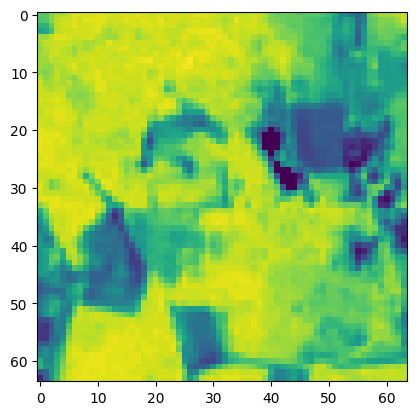

In [7]:
plt.imshow(input_img[0, 32, :, :])

In [7]:
np.unique(input_mask)

array([ 0,  6,  7,  8, 10, 12, 31], dtype=uint8)

In [8]:
#clear memory
all_input_img = 0
all_input_mask = 0

In [9]:
input_mask[input_mask==0]=0
input_mask[input_mask==6]=1
input_mask[input_mask==7]=2
input_mask[input_mask==8]=3
input_mask[input_mask==10]=0
input_mask[input_mask==12]=0
input_mask[input_mask==31]=0

#input_mask = np.repeat(input_mask[:, np.newaxis, :, :], repeats=64, axis=1)

#input_img[input_img==0] = np.median(input_img)

'''for m in range(64):
    for i in range(64):
        for j in range(64):
            input_img[m,:,i,j][input_img[m,:,i,j]==0] = np.median(input_img[m,:,i,j]).astype(np.uint8)'''

lai_uniques = np.unique(input_img)

for n in range(len(lai_uniques)):
  input_img[input_img==lai_uniques[n]]=n
input_img = input_img.astype(np.uint8)

In [10]:
# clear memory 
lai_uniques = 0

In [11]:
n_classes=4

In [12]:
#Convert grey image to 3 channels by copying channel 3 times.
#We do this as our unet model expects 3 channel input. 

train_img = np.stack((input_img,)*3, axis=-1)
train_mask = np.expand_dims(input_mask, axis=4)


train_mask_cat = to_categorical(train_mask, num_classes=n_classes)


X_train, X_test, y_train, y_test = train_test_split(train_img, train_mask_cat, test_size = 0.10, random_state = 0)



In [13]:
# emptying space 
train_img = 0
train_mask_cat = 0
train_mask = 0
input_mask = 0
input_img = 0

In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape    

((633, 64, 64, 64, 3),
 (71, 64, 64, 64, 3),
 (633, 64, 64, 64, 4),
 (71, 64, 64, 64, 4))

In [15]:

# Loss Function and coefficients to be used during training:
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


Backbones: ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'seresnet18', 'seresnet34', 'seresnet50', 'seresnet101', 'seresnet152', 'seresnext50', 'seresnext101', 'senet154', 'resnext50', 'resnext101', 'vgg16', 'vgg19', 'densenet121', 'densenet169', 'densenet201', 'inceptionresnetv2', 'inceptionv3', 'mobilenet', 'mobilenetv2', 'efficientnetb0', 'efficientnetb1', 'efficientnetb2', 'efficientnetb3', 'efficientnetb4', 'efficientnetb5', 'efficientnetb6', 'efficientnetb7']

In [16]:
#Define parameters for our model.

encoder_weights = 'imagenet'
BACKBONE = 'vgg16'  #Try vgg16, efficientnetb7, inceptionv3, resnet50
activation = 'softmax'
patch_size = 64
n_classes = 4
channels=3

LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss (car: 1.; pedestrian: 2.; background: 0.5;)
dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

2024-04-09 14:07:09.377381: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-09 14:07:09.379157: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-09 14:07:09.380845: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [17]:
preprocess_input = sm.get_preprocessing(BACKBONE)

In [16]:
#Preprocess input data - otherwise you end up with garbage resutls 
# and potentially model that does not converge.
X_train_prep = preprocess_input(X_train)
X_test_prep = preprocess_input(X_test)

In [17]:
X_train = 0
X_test = 0

In [18]:
#Define the model. Here we use Unet but we can also use other model architectures from the library.
model = sm.Unet(BACKBONE, classes=n_classes, 
                input_shape=(patch_size, patch_size, patch_size, channels), 
                encoder_weights=encoder_weights,
                activation=activation)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 64, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv3D)       (None, 64, 64, 64, 64)       5248      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv3D)       (None, 64, 64, 64, 64)       110656    ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling3D)  (None, 32, 32, 32, 64)       0         ['block1_conv2[0][0]']        
                                                                                              

In [19]:
#Fit the model
history=model.fit(X_train_prep, 
          y_train,
          batch_size=8, 
          epochs=500,
          verbose=1,
          validation_data=(X_test_prep, y_test))

Epoch 1/500


2024-04-08 11:21:04.154362: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-04-08 11:21:06.801636: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55eef3f5def0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-08 11:21:06.801669: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-04-08 11:21:06.801674: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-04-08 11:21:06.801678: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-04-08 11:21:06.801682: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-04-08 11:21:06.806201: I tensorflow/compiler/mlir/tensorflow/utils/dump_

80/80 [==============================] - 33s 218ms/step - loss: 0.9836 - iou_score: 0.1502 - f1-score: 0.1754 - val_loss: 0.9659 - val_iou_score: 0.1963 - val_f1-score: 0.2326
Epoch 2/500
80/80 [==============================] - 12s 153ms/step - loss: 0.9551 - iou_score: 0.4794 - f1-score: 0.4958 - val_loss: 0.9631 - val_iou_score: 0.3619 - val_f1-score: 0.4015
Epoch 3/500
80/80 [==============================] - 12s 152ms/step - loss: 0.9502 - iou_score: 0.4966 - f1-score: 0.5112 - val_loss: 0.9523 - val_iou_score: 0.4420 - val_f1-score: 0.4560
Epoch 4/500
80/80 [==============================] - 12s 153ms/step - loss: 0.9487 - iou_score: 0.4968 - f1-score: 0.5113 - val_loss: 0.9526 - val_iou_score: 0.4426 - val_f1-score: 0.4564
Epoch 5/500
80/80 [==============================] - 12s 154ms/step - loss: 0.9478 - iou_score: 0.4932 - f1-score: 0.5085 - val_loss: 0.9498 - val_iou_score: 0.4403 - val_f1-score: 0.4553
Epoch 6/500
80/80 [==============================] - 12s 154ms/step - lo

In [20]:
#Save model for future use
model.save('/home/luser/stelar_3d/storage/saved_model/3D_model_vgg16_500epochs.h5')

/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


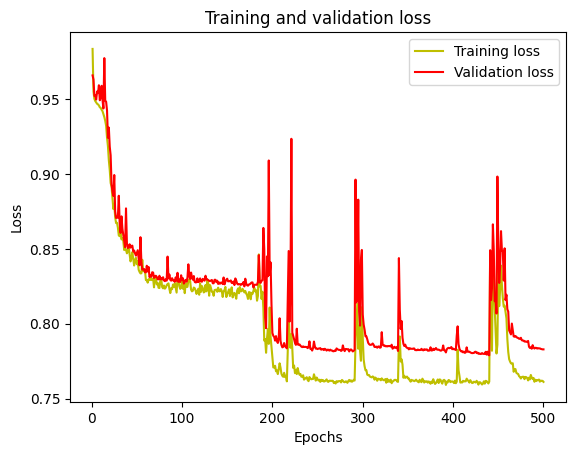

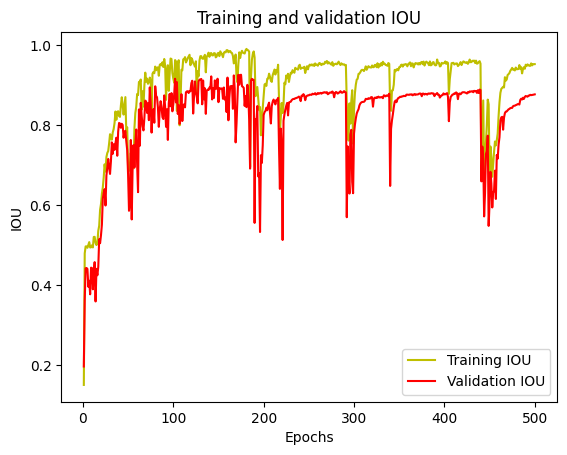

In [21]:
###
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [18]:
#Load the pretrained model for testing and predictions. 
from keras.models import load_model
my_model = load_model('/home/luser/stelar_3d/storage/saved_model/3D_model_vgg16_500epochs.h5', compile=False)
#If you load a different model do not forget to preprocess accordingly. 


In [19]:
X_test.shape

(71, 64, 64, 64, 3)

In [20]:
#Predict on the test data
'''X_test = X_train[:10]
y_test = y_train[:10]'''
y_pred=my_model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=4)
y_test_argmax = np.argmax(y_test, axis=4)


2024-04-09 14:07:12.900600: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907


3/3 [==============================] - 10s 759ms/step


In [21]:
print(y_pred_argmax.shape)
print(y_test_argmax.shape)
print(np.unique(y_pred_argmax))

(71, 64, 64, 64)
(71, 64, 64, 64)
[0 1 3]


In [22]:
#Using built in keras function for IoU
#Only works on TF > 2.0
#from keras.metrics import MeanIoU
#from keras.metrics import MeanIoU
#n_classes = 4
#IOU_keras = MeanIoU(num_classes=n_classes)  
#IOU_keras.update_state(y_test_argmax, y_pred_argmax)
#print("Mean IoU =", IOU_keras.result().numpy())

In [96]:
#Test some random images
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number-1]
ground_truth=y_test[test_img_number-1]

test_img_input=np.expand_dims(test_img, 0)
test_img_input1 = preprocess_input(test_img_input)

test_pred1 = my_model.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=4)[0,:,:,:]
print(test_prediction1.shape)

result_image = np.median(test_prediction1, axis=0)

avg_image = np.round(np.mean(test_prediction1, axis=0)).astype(np.uint8)

ground_truth_argmax = np.argmax(ground_truth, axis=3)
print(test_img.shape)

1/1 [==============================] - 0s 39ms/step
(64, 64, 64)
(64, 64, 64, 3)


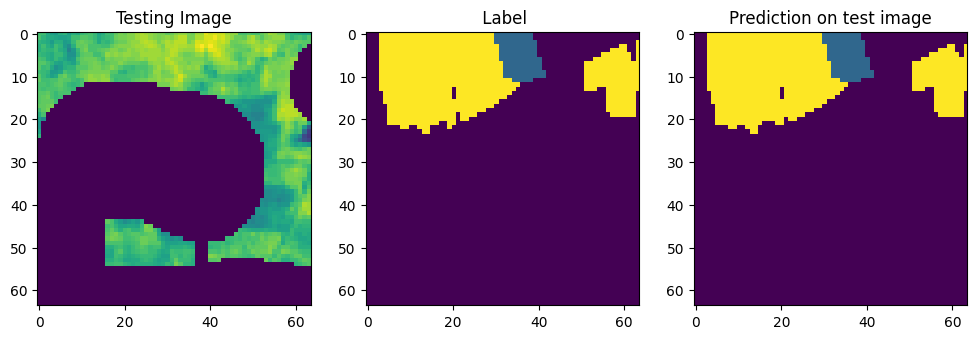

In [97]:
#Plot individual slices from test predictions for verification
slice = 8
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[slice,:,:,0])
plt.subplot(232)
plt.title(' Label')
plt.imshow(ground_truth_argmax[slice,:,:])
plt.subplot(233)
'''plt.title('Prediction on test image')
plt.imshow(test_prediction1[slice,:,:])
plt.show()'''

plt.title('Prediction on test image')
plt.imshow(result_image)
plt.show()


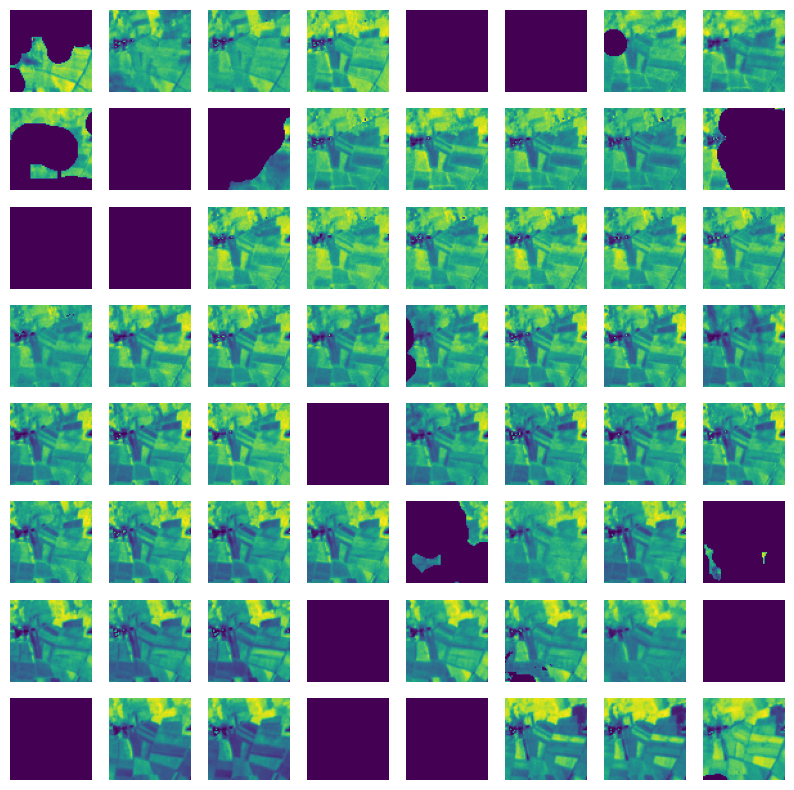

In [98]:
# plot 64 figures of test_img in 8 x 8 grid 
plt.figure(figsize=(10,10))
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(test_img[i,:,:, 1])
    plt.axis('off')

Now segment the full volume using the trained model.

In [32]:
#Break the large image (volume) into patches of same size as the training images (patches)
large_image = io.imread('/home/luser/stelar_3d/drive/MyDrive/Colab Notebooks/data/sandstone_3d/all_images/448_images_512x512.tif')
patches = patchify(large_image, (64, 64, 64), step=64)  #Step=256 for 256 patches means no overlap
print(large_image.shape)
print(patches.shape)

(448, 512, 512)
(7, 8, 8, 64, 64, 64)


In [33]:
# Predict each 3D patch   
predicted_patches = []
for i in range(patches.shape[0]):
  for j in range(patches.shape[1]):
    for k in range(patches.shape[2]):
      #print(i,j,k)
      single_patch = patches[i,j,k, :,:,:]
      single_patch_3ch = np.stack((single_patch,)*3, axis=-1)
      single_patch_3ch_input = preprocess_input(np.expand_dims(single_patch_3ch, axis=0))
      single_patch_prediction = my_model.predict(single_patch_3ch_input)
      single_patch_prediction_argmax = np.argmax(single_patch_prediction, axis=4)[0,:,:,:]
      predicted_patches.append(single_patch_prediction_argmax)
      


1/1 [==============================] - 0s 37ms/step


In [34]:
#Convert list to numpy array
predicted_patches = np.array(predicted_patches)
print(predicted_patches.shape)

(448, 64, 64, 64)


In [35]:
#Reshape to the shape we had after patchifying
predicted_patches_reshaped = np.reshape(predicted_patches, 
                                        (patches.shape[0], patches.shape[1], patches.shape[2],
                                         patches.shape[3], patches.shape[4], patches.shape[5]) )
print(predicted_patches_reshaped.shape)

(7, 8, 8, 64, 64, 64)


In [36]:
#Repach individual patches into the orginal volume shape
reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
print(reconstructed_image.shape)

(448, 512, 512)


In [37]:
print(reconstructed_image.dtype)

int64


In [38]:
#Convert to uint8 so we can open image in most image viewing software packages
reconstructed_image=reconstructed_image.astype(np.uint8)
print(reconstructed_image.dtype)

uint8


In [39]:
#Now save it as segmented volume.
from tifffile import imsave
imsave('/home/luser/stelar_3d/drive/MyDrive/Colab Notebooks/data/sandstone_3d/all_images/segmented.tif', reconstructed_image)
    

/tmp/ipykernel_3732542/1785818526.py:3: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  imsave('/home/luser/stelar_3d/drive/MyDrive/Colab Notebooks/data/sandstone_3d/all_images/segmented.tif', reconstructed_image)


In [40]:
#If you would like to save the volume as multichannel dataset....

In [41]:
print(np.unique(reconstructed_image))

[0 1 2 3]


In [42]:
#Seperate each channel/segment to be combined as multiple channels.
num_segments=4
segm0 = (reconstructed_image == 0)
segm1 = (reconstructed_image == 1)
segm2 = (reconstructed_image == 2)
segm3 = (reconstructed_image == 3)

final = np.empty((reconstructed_image.shape[0], reconstructed_image.shape[1], reconstructed_image.shape[2], num_segments))
final[:,:,:,0] = segm0
final[:,:,:,1] = segm1
final[:,:,:,2] = segm2
final[:,:,:,3] = segm3

In [ ]:
#Use APEER OMETIFF library to read and write multidimensional images
!pip install apeer-ometiff-library

In [43]:
from apeer_ometiff_library import io

ModuleNotFoundError: No module named 'apeer_ometiff_library'

In [37]:
# Expand image array to 5D of order (T, Z, C, X, Y)
# This is the convention for OMETIFF format as written by APEER library
final = np.expand_dims(final, axis=0)
final=np.swapaxes(final, 2, 4)

final = final.astype(np.int8)



In [ ]:
print("Shape of the segmented volume is: T, Z, C, X, Y ", final.shape)
print(final.dtype)


In [ ]:
# Write dataset as multi-dimensional OMETIFF *image*
io.write_ometiff("/home/luser/stelar_3d/drive/MyDrive/Colab Notebooks/data/sandstone_3d/all_images/segmented_multi_channel.ome.tiff", final)